In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#cd /content/drive/MyDrive/multi_mainPJ

In [ ]:
!pip install transformers
!pip install sentencepiece

In [ ]:
import pickle
from sklearn.model_selection import train_test_split
import logging
logging.basicConfig(level=logging.ERROR)
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/monologg/KoBERT-NER/master/tokenization_kobert.py", filename="tokenization_kobert.py")
#from transformers import *
import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers import TFBertModel
from tokenization_kobert import KoBertTokenizer
import tensorflow as tf

from tensorflow.keras.layers import Embedding, Dense, GRU, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
import os

# 모델 입력 데이터 생성
### `MAX_LEN`
- 리뷰 한개당 토큰 개수 분포 확인 (문장 길이)
- 문장 길이를 64자로 제한하더라도 원본 내용을 충분히 잘 표현할 수 있다고 판단
  - 전체 문장 중 95.89%가 64자 이하이기 때문

In [ ]:
# 영화리뷰 데이터 불러오기
with open("/content/drive/MyDrive/multi_mainPJ/cleaned_movie_review.pkl","rb") as m:
    movie_df = pickle.load(m)

X_train, X_test, y_train, y_test = train_test_split(movie_df['document'], movie_df['label'],stratify=movie_df['label'], shuffle=True, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

y_train = np.array(y_train)
y_test = np.array(y_test)

MAX_LEN = 64
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')
def tokenize_to_padding(data):
  global tokenizer
  tokenizer.pad_token_id = 0
  inputs = tokenizer(data.tolist(),
                        max_length = MAX_LEN,
                        padding='max_length',
                        truncation = True,
                        return_tensors="tf")
  input_ids = inputs['input_ids']
  return input_ids

train_x= tokenize_to_padding(X_train)
test_x = tokenize_to_padding(X_test)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


In [ ]:
train_x

<tf.Tensor: shape=(154332, 64), dtype=int32, numpy=
array([[   2, 2293, 7096, ...,    0,    0,    0],
       [   2, 1189, 2372, ...,    0,    0,    0],
       [   2,  517, 6538, ...,    0,    0,    0],
       ...,
       [   2, 3394, 6371, ...,    0,    0,    0],
       [   2, 3093, 6964, ...,    0,    0,    0],
       [   2, 4924, 1189, ...,    0,    0,    0]], dtype=int32)>

In [ ]:
y_train

array([1, 1, 1, ..., 0, 0, 1])

In [ ]:
print("x_train.shape : ", train_x.shape)
print("y_train.shape : ", y_train.shape)

x_train.shape :  (154332, 64)
y_train.shape :  (154332,)


### `VOCAB_SIZE`
- 이미 답어집합의 크기가 작기 때문에 희귀단어를 따로 고려하지 않음
- 버트토크나이저에서 문장 앞뒤로 추가되는 cls, sep와 제로패딩을 고려

In [ ]:
vocab_size = len(tokenizer) + 3

In [ ]:
vocab_size

8005

In [ ]:
# w = len(np.unique(train_x))
# print("단어 집합의 크기 (vocab size):", w)

In [ ]:
# tensor = tf.constant(train_x)
# flattened_tensor = tf.reshape(tensor, [-1])
# unique_tokens = set(flattened_tensor.numpy())

# num_unique_tokens = len(unique_tokens)
# print("고유한 단어들의 개수:", num_unique_tokens)


모델 평가 시각화 함수

In [ ]:
import matplotlib.pyplot as plt

def eval_plot(test_eval, test_reports):
  plt.clf()
  plt.figure(figsize=(8, 3))

  plt.subplot(121)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'], loc='upper right')

  plt.subplot(122)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'], loc='lower right')

  plt.suptitle(f'test_loss: {round(test_eval[0],4)} test_acc: {round(test_eval[1],4)}', fontsize=10, y=1.05)

  plt.tight_layout()
  plt.show()

  print(test_reports)

# 학습
- 영화 리뷰 학습

- 임베딩 레이어 차원(`EMB_DIM`) : 100~300 설정
  - 과대적합 방지 위해 너무 크지 않게 설정
- RNN Layer의 유닛차원 : emb_dim 보다 상대적으로 크게 설정
  - 중간 크기의 임베딩 차원은 모델의 표현 능력을 충분히 갖출 수 있음
- 은닉층 활성함수(`activation`) : tanh
  - relu와 비교했을 때 tanh의 속도가 빠른 결과
- 배치사이즈(`BATCH_SIZE`) : 32
- 학습률(`LEARNING_RATE`) : 0.001
  - 데이터가 많고 모델이 크므로 학습률을 작게 설정

## 8차 학습 (최종 선정 모델)
이전 학습 : 과대적합이 지속적으로 발생</br>
challenge : 과대적합 방지
- `EMB_DIM` : 300
- Adam
- 드롭아웃 적용
  - 목적 : 모델의 복잡도 줄이기
  - 은닉층의 뉴런 수가 비교적 많은 레이어를 거친 다음 단계에서 더 높은 비율의 dropout을 적용하여 랜덤하게 일부 뉴런을 비활성화 시킴

## 결과
- test_loss : 0.4647 / test_acc : 0.7816
- 검증손실과 훈련손실이 에폭 15를 기점으로 점차 수렴 (정확도 또한) -> 과적합 해결


- accuracy : 0.78 / F1-score : 0.78 (균형적)

In [ ]:
EMB_DIM = 300
VOCAB_SIZE = 8005
EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.001
num = 8

model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMB_DIM)) # vocab_size : input_dim , output_dim
model.add(Dropout(0.2))
model.add(GRU(512, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, epsilon=1e-06)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) # adam
print(model.summary())

In [ ]:
history = model.fit(train_x, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)
model.save(f'/content/drive/MyDrive/multi_mainPJ/최종/bertTokenizer_{num}.h5')

Epoch 1/30
3859/3859 [==============================] - 91s 23ms/step - loss: 0.6951 - accuracy: 0.5005 - val_loss: 0.6936 - val_accuracy: 0.5005
Epoch 2/30
3859/3859 [==============================] - 52s 14ms/step - loss: 0.4510 - accuracy: 0.7773 - val_loss: 0.3742 - val_accuracy: 0.8297
Epoch 3/30
3859/3859 [==============================] - 51s 13ms/step - loss: 0.3533 - accuracy: 0.8442 - val_loss: 0.3598 - val_accuracy: 0.8383
Epoch 4/30
3859/3859 [==============================] - 49s 13ms/step - loss: 0.3205 - accuracy: 0.8616 - val_loss: 0.3626 - val_accuracy: 0.8393
Epoch 5/30
3859/3859 [==============================] - 50s 13ms/step - loss: 0.2942 - accuracy: 0.8757 - val_loss: 0.3622 - val_accuracy: 0.8448
Epoch 6/30
3859/3859 [==============================] - 50s 13ms/step - loss: 0.2718 - accuracy: 0.8860 - val_loss: 0.3774 - val_accuracy: 0.8415
Epoch 7/30
3859/3859 [==============================] - 50s 13ms/step - loss: 0.2545 - accuracy: 0.8947 - val_loss: 0.3891 -

1206/1206 [==============================] - 5s 4ms/step


<Figure size 640x480 with 0 Axes>

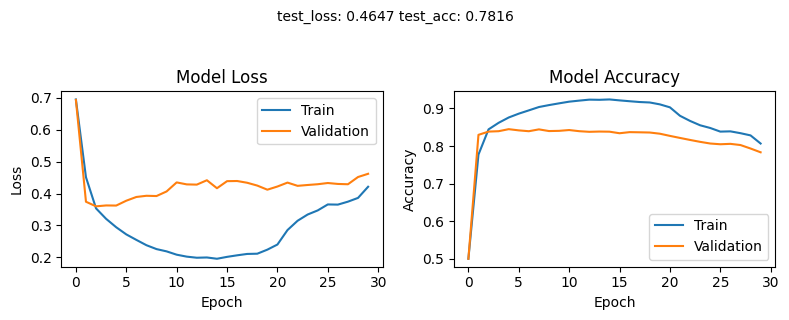

              precision    recall  f1-score   support

           0       0.78      0.79      0.78     19336
           1       0.79      0.77      0.78     19248

    accuracy                           0.78     38584
   macro avg       0.78      0.78      0.78     38584
weighted avg       0.78      0.78      0.78     38584



In [ ]:
test_eval2 = model.evaluate(test_x, y_test, batch_size=64)
pred_test2 = model.predict(test_x)
test_reports2 = classification_report(y_test, np.round(pred_test2,0))
eval_plot(test_eval2, test_reports2)

## 9차 _ LSTM
- GRU 모델과 같은 파라미터로 LSTM 학습 해봄
## 결과
- test_loss : 0.6297 / test_acc : 0.831
- 스코어는 비교적 높지만 6에폭 이후로 validation loss가 급격하게 상승하여​ 그래프가 수렴하지 않아 판단 과대적합이 발생했다고 판단

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU, Dropout, LSTM
EMB_DIM = 300
VOCAB_SIZE = 8005
EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.001
num = 9

model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMB_DIM)) # vocab_size : input_dim , output_dim
model.add(Dropout(0.2))
model.add(LSTM(512, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, epsilon=1e-06)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) # adam
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         2401500   
                                                                 
 dropout_1 (Dropout)         (None, None, 300)         0         
                                                                 
 lstm (LSTM)                 (None, 512)               1665024   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,132,317
Trainable params: 4,132,317
No

In [ ]:
history = model.fit(train_x, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)
model.save(f'/content/drive/MyDrive/multi_mainPJ/최종/bertTokenizer_{num}.h5')

Epoch 1/30
3859/3859 [==============================] - 109s 26ms/step - loss: 0.6961 - accuracy: 0.4986 - val_loss: 0.6948 - val_accuracy: 0.4995
Epoch 2/30
3859/3859 [==============================] - 57s 15ms/step - loss: 0.6956 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 3/30
3859/3859 [==============================] - 56s 15ms/step - loss: 0.6953 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.4995
Epoch 4/30
3859/3859 [==============================] - 55s 14ms/step - loss: 0.6959 - accuracy: 0.5016 - val_loss: 0.6934 - val_accuracy: 0.4995
Epoch 5/30
3859/3859 [==============================] - 55s 14ms/step - loss: 0.6958 - accuracy: 0.5012 - val_loss: 0.7018 - val_accuracy: 0.5153
Epoch 6/30
3859/3859 [==============================] - 53s 14ms/step - loss: 0.6954 - accuracy: 0.5015 - val_loss: 0.6945 - val_accuracy: 0.5005
Epoch 7/30
3859/3859 [==============================] - 53s 14ms/step - loss: 0.6955 - accuracy: 0.5026 - val_loss: 0.6923 

1206/1206 [==============================] - 6s 4ms/step


<Figure size 640x480 with 0 Axes>

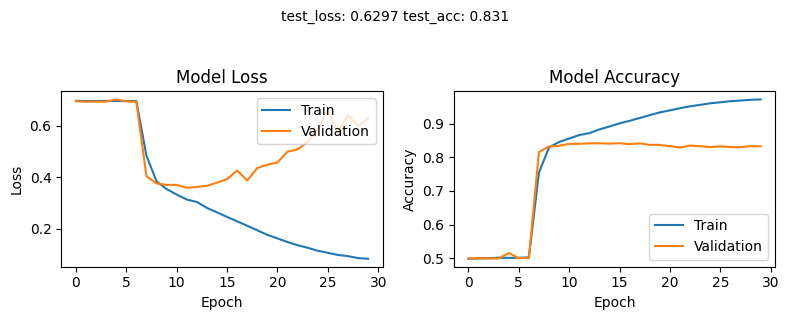

              precision    recall  f1-score   support

           0       0.84      0.82      0.83     19336
           1       0.83      0.84      0.83     19248

    accuracy                           0.83     38584
   macro avg       0.83      0.83      0.83     38584
weighted avg       0.83      0.83      0.83     38584



In [ ]:
test_eval2 = model.evaluate(test_x, y_test, batch_size=64)
pred_test2 = model.predict(test_x)
test_reports2 = classification_report(y_test, np.round(pred_test2,0))
eval_plot(test_eval2, test_reports2)

# 서비스 적용
## 도서리뷰 긍부정 분류
- 학습된 최종 모델을 활용해 도서 리뷰의 감성점수 예측(긍부정 분류)

In [ ]:
from tensorflow.keras.models import load_model
num = 8 # 8차 결과

# 모델 불러오기
loaded_model = load_model('/content/drive/MyDrive/multi_mainPJ/최종/bertTokenizer_6.h5')
# 크롤링한 도서리뷰 데이터 불러오기
with open("/content/drive/MyDrive/multi_mainPJ/filtered_review_df2.pickle","rb") as m:
    book_df = pickle.load(m)

X_pred = book_df['reviews']

# 도서 리뷰 데이터 토큰화 -> 정수인코딩,패딩
MAX_LEN = 64
#tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')
def tokenize_to_padding(data):
  global tokenizer
  tokenizer.pad_token_id = 0
  inputs = tokenizer(data.tolist(),
                        max_length = MAX_LEN,
                        padding='max_length',
                        truncation = True,
                        return_tensors="tf")
  input_ids = inputs['input_ids']
  return input_ids

pred_x= tokenize_to_padding(X_pred)

# 훈련된 최종 모델에 predict
result = loaded_model.predict(pred_x)

# 데이터 프레임 생성
df = book_df.copy()

import numpy as np
df['pred_prob'] = result
df['pred_label'] = np.round(result,0)

# with open(f'/content/drive/MyDrive/multi_mainPJ/최종/7_30_df{num}.pkl','wb') as d:
#   pickle.dump(df, d)

# service_df = df.drop(['score','date','label','pred_prob'], axis=1)
# with open('/content/drive/MyDrive/최종플젝/데이터/pred_sentiment_service_df.pkl','wb') as a:
#   pickle.dump(service_df, a)

4257/4257 [==============================] - 18s 4ms/step


In [ ]:
book_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136202 entries, 0 to 136201
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   isbn13   136202 non-null  int64         
 1   score    136202 non-null  int64         
 2   reviews  136202 non-null  object        
 3   date     136202 non-null  datetime64[ns]
 4   label    136202 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 5.2+ MB


In [ ]:
df

,isbn13,score,reviews,date,label,pred_prob,pred_label
0,9791168473690,10,선생님 항상 존경합니다 저도 한 때는 만원 들고 가출한 적이 있으나 선생님의 뼈아픈...,2023-01-20,1,0.998488,1.0
1,9791168473690,2,와 최악이다 이게 책인가 반품 신청함 말도 너무 험하고 몇 챕터 읽었는데 기분만 상했음,2023-03-04,0,0.001551,0.0
2,9791168473690,4,이전에 비매품으로 나왔던 책도 소장중입니다만 수정본이라도 내용상 크게 변한 건 없군...,2023-03-05,0,0.001553,0.0
3,9791168473690,2,가르침 이란 제목에서 알아봤어야 했는데,2023-03-03,0,0.049334,0.0
4,9791168473690,10,지금 현재 흙수저에서 부자가 된 사람들의 대다수는 세이노 선생님이 멘토셨다 약 년전...,2023-01-22,1,0.998492,1.0
...,...,...,...,...,...,...,...
136197,9788997323524,10,유통업체에 푸드코트 납품 입점하실 분들은 이 자료 이용하셔서 발송하시고 매장관리자 ...,2012-08-23,1,0.114265,0.0
136198,9788997323418,8,유통쪽에서 일하는지라 본사말고 개인음식점들 컨텍할 자료가 필요했는데 괜찮네요 정보가...,2012-04-25,0,0.998490,1.0
136199,9788960237872,8,출산률이 마음대로 될까 하는 생각이 드는 목차가 있네요,2012-05-17,0,0.507220,1.0
136200,9788982732362,10,근데 이사람 왜 파산했을까요,2016-10-01,1,0.655236,1.0


## 최종 선정 모델 리뷰 확인하기
- 라벨 별로 예측 결과 파악
## 결론
- 도서리뷰로 학습했을 때보다 영화리뷰로 학습한 예측 성능이 눈으로 보기에도 더 좋아보임
- 영화리뷰 데이터의 특성 때문이라 예상
  - 영화리뷰의 감성표현이 상대적으로 많이 분포
  - 도서리뷰는 감성을 표현하는 단어보다 책 내용에 대한 단어 위주


In [ ]:
with open("/content/drive/MyDrive/multi_mainPJ/최종/7_30_df8.pkl","rb") as m:
    dfdf = pickle.load(m)

In [ ]:
dfdf
# pred_prob 이 예측확률, pred_label이 예측된 라벨

,isbn13,score,reviews,date,label,pred_prob,pred_label
0,9791168473690,10,선생님 항상 존경합니다 저도 한 때는 만원 들고 가출한 적이 있으나 선생님의 뼈아픈...,2023-01-20,1,0.848876,1.0
1,9791168473690,2,와 최악이다 이게 책인가 반품 신청함 말도 너무 험하고 몇 챕터 읽었는데 기분만 상했음,2023-03-04,0,0.020750,0.0
2,9791168473690,4,이전에 비매품으로 나왔던 책도 소장중입니다만 수정본이라도 내용상 크게 변한 건 없군...,2023-03-05,0,0.070604,0.0
3,9791168473690,2,가르침 이란 제목에서 알아봤어야 했는데,2023-03-03,0,0.476122,0.0
4,9791168473690,10,지금 현재 흙수저에서 부자가 된 사람들의 대다수는 세이노 선생님이 멘토셨다 약 년전...,2023-01-22,1,0.659326,1.0
...,...,...,...,...,...,...,...
136197,9788997323524,10,유통업체에 푸드코트 납품 입점하실 분들은 이 자료 이용하셔서 발송하시고 매장관리자 ...,2012-08-23,1,0.627028,1.0
136198,9788997323418,8,유통쪽에서 일하는지라 본사말고 개인음식점들 컨텍할 자료가 필요했는데 괜찮네요 정보가...,2012-04-25,0,0.239552,0.0
136199,9788960237872,8,출산률이 마음대로 될까 하는 생각이 드는 목차가 있네요,2012-05-17,0,0.878579,1.0
136200,9788982732362,10,근데 이사람 왜 파산했을까요,2016-10-01,1,0.132264,0.0


In [ ]:
dfdf[dfdf['pred_label']==1.0]

,isbn13,score,reviews,date,label,pred_prob,pred_label
0,9791168473690,10,선생님 항상 존경합니다 저도 한 때는 만원 들고 가출한 적이 있으나 선생님의 뼈아픈...,2023-01-20,1,0.848876,1.0
4,9791168473690,10,지금 현재 흙수저에서 부자가 된 사람들의 대다수는 세이노 선생님이 멘토셨다 약 년전...,2023-01-22,1,0.659326,1.0
6,9791168473690,2,드디어 오늘 페이지까지 다 읽었다 일하면서 읽느라 주일이 걸렸다 다 읽고 나서 드는...,2023-03-06,0,0.734108,1.0
8,9791168473690,10,신간 책을 출판사의 노고랑 종이값만 받네 멋진 책이다,2023-01-28,1,0.605458,1.0
10,9791168473690,10,구슬이 서말이라도 꿰어야 보배가 되듯이 경험에서 우러나온 진심의 충고를 잘 받아들여...,2023-03-11,1,0.778492,1.0
...,...,...,...,...,...,...,...
136193,9788997519842,6,사고 싶은데 팔렸나요,2017-03-03,0,0.714644,1.0
136195,9788996767541,8,저자가 지적하는 자영업의 핵심 업의 본질을 깊이 알고 거기에 자아를 반영해 나만의 ...,2016-06-07,0,0.723166,1.0
136196,9788997323616,8,출판사에 영업하시는 분들께 대박 추천하는 자료다 전자책 으로 전환하려는 출판사가 굉...,2012-09-24,0,0.759065,1.0
136197,9788997323524,10,유통업체에 푸드코트 납품 입점하실 분들은 이 자료 이용하셔서 발송하시고 매장관리자 ...,2012-08-23,1,0.627028,1.0


# 모델 아키텍처


In [ ]:
!pip install pydot

In [ ]:
!pip install pydotplus

In [ ]:
# 모델 불러오기
loaded_model = load_model('/content/drive/MyDrive/multi_mainPJ/최종/bertTokenizer_8.h5')

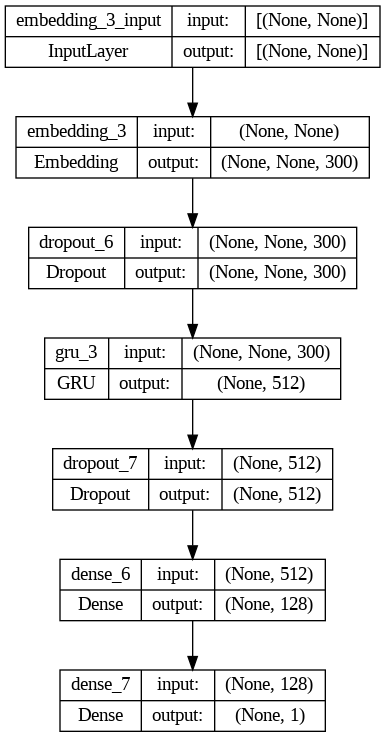

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# 모델을 로드하는 코드 (예시)
# loaded_model = tf.keras.models.load_model('path/to/your/model')

# 모델 구조 시각화
plot_model(loaded_model, show_shapes=True, to_file='model.png')